# Your mission

You started working in a financial institution. You manager Mark is insterested in investing and trading **Bitcoin** to diversify his portfolio. So he turned to you to develop a crypto trading bot.

A **crypto trading bot** is a computer program with an underlying predictive model that automatically outputs a predicted day to day price for the next 30 days based on the history of Bitcoin market price and Blockchain variables. 

Your mission is to train an accurate predictive model with the lowest mean squared error. Mark is a very technical guy, he likes to understand all **technical details** and would like you to **compare the performances of classical models and neural-net based models**.

Your **target variable** is the Bitcoin Market price.

**Data source** : https://blockchain.info/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import helper_functions as hf

CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
%matplotlib inline

# Data Exploration

In this section, you are to explore the data. You are to fulfill the following tasks:
- **Univariate analysis**
    - study the Bitcoin market price time series, in terms of its trend, cycle, seasonality, and stationnarity 
    - **Tips**: you can analyse ACF, PACF plots, perform Augmented Dickey-Fuller test
- **Multivariate analysis**
    - study other blockchain variables, retrieve insights
    - study the correlation between the Bitcoin market price and other blockchain variables 
    - **Tips**: Pearson correlation

## Univariate analysis

In [2]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), 
                            delimiter=",")


In [3]:
df_blockchain.head()

,Date,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
0,2011-09-13,6.88,45.908451,0.0,12.018816,1.777774e+06,52318.011503,0.0,592.190091,0.019009,...,7.666766,12622.0,6519.0,1497195.0,6519.0,358543.612114,58615.641320,403275.612279,7.257416e+06,5.022014e+07
1,2011-09-14,6.19,42.465753,0.0,13.263925,1.755425e+06,48306.468911,0.0,594.907367,0.018007,...,7.369408,12408.0,6200.0,1503780.0,6200.0,302619.024544,74521.484625,461287.989830,7.264662e+06,4.540930e+07
2,2011-09-15,5.92,41.500000,0.0,12.914875,1.755425e+06,60431.444952,0.0,597.554226,0.018240,...,7.333913,12988.0,6474.0,1509972.0,6474.0,299226.130646,79422.402932,470180.625359,7.272284e+06,4.322228e+07
3,2011-09-16,5.58,52.176471,0.0,10.995096,1.755425e+06,34345.021913,0.0,600.362512,0.022136,...,5.466341,12059.0,6209.0,1516381.0,6209.0,674606.861338,82696.853247,461448.441118,7.279040e+06,4.088136e+07
4,2011-09-17,5.18,40.701493,0.0,10.733308,1.755425e+06,36805.913687,0.0,602.995510,0.017116,...,6.489054,10988.0,5454.0,1522600.0,5454.0,354198.945778,68238.166521,353473.702578,7.285375e+06,3.801833e+07


In [4]:
df_blockchain.columns.sort_values().shape

(23,)

### Plot the data, trend of the market price

In [5]:
date=df_blockchain["Date"]
temps=[i for i in range(len(np.array(date)))]
prix=df_blockchain["market-price"]

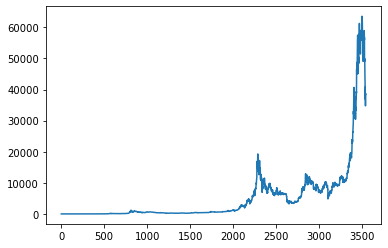

In [6]:
plt.plot(temps,np.array(prix))

The trend here is a long-term increase. It seems to globally rise that since the day 2000 (beginning of 2018). The process doesn't seem to be stationnary

Text(0.5, 1.0, 'Evolution of market price between 2013-08-13 and 2014-12-26')

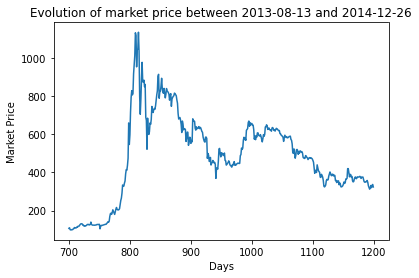

In [7]:
plt.plot(temps[700:1200],np.array(prix)[700:1200])
plt.xlabel("Days")
plt.ylabel("Market Price")
plt.title("Evolution of market price between 2013-08-13 and 2014-12-26")

### Cycles

2017-03-05 2018-10-26


Text(0.5, 1.0, 'Evolution of market price between 2017-03-05 and 2018-10-26')

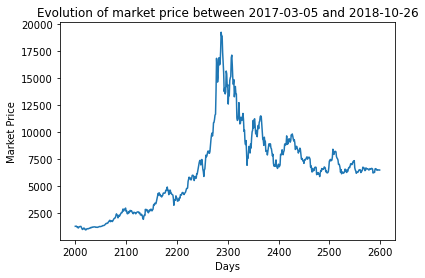

In [8]:
plt.plot(temps[2000:2600],np.array(prix)[2000:2600])
print(date[2000],date[2600])
plt.xlabel("Days")
plt.ylabel("Market Price")
plt.title("Evolution of market price between 2017-03-05 and 2018-10-26")

Text(0.5, 1.0, 'Evolution of market price since 2020-06-17')

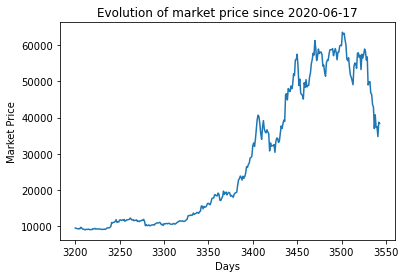

In [9]:
plt.plot(temps[3200:],np.array(prix)[3200:])
plt.xlabel("Days")
plt.ylabel("Market Price")
plt.title("Evolution of market price since 2020-06-17")

There are not specific periods of time between the patterns, but it seems to have cycles. we can identify three cycles : the first one between 2013-08-13 and 2014-12-26, the second one between 2017-03-05 and 2018-10-26, and the last one from 2020-06-17.

### Seasonality, stationnarity

In [10]:
temps_year=[i for i in range(365)]

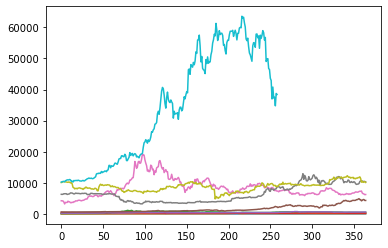

In [11]:
plt.plot(np.array(temps_year),np.array(prix)[:365])
plt.plot(np.array(temps_year),np.array(prix)[365:2*365])
plt.plot(np.array(temps_year),np.array(prix)[2*365:3*365])
plt.plot(np.array(temps_year),np.array(prix)[3*365:4*365])
plt.plot(np.array(temps_year),np.array(prix)[4*365:5*365])
plt.plot(np.array(temps_year),np.array(prix)[5*365:6*365])
plt.plot(np.array(temps_year),np.array(prix)[6*365:7*365])
plt.plot(np.array(temps_year),np.array(prix)[7*365:8*365])
plt.plot(np.array(temps_year),np.array(prix)[8*365:9*365])
plt.plot(np.array(temps_year[:259]),np.array(prix)[9*365:])

We conclude that there are no seasonalities in the market price of the Bitcoin. We can conclude that this is not stationnary in additon.

### Autocorrelation and Partial correlation

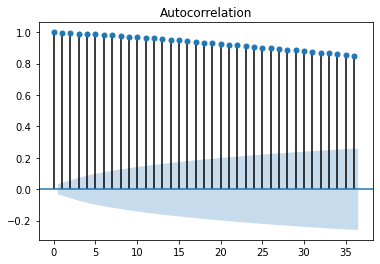

In [12]:
plot_acf(df_blockchain["market-price"]);

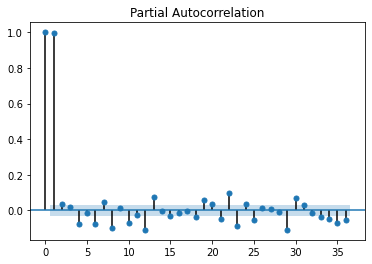

In [13]:
plot_pacf(df_blockchain["market-price"]);

By analysing the autocorrelation and the partiel autocorellation, we can conclude that a MA model is not possible for the market price of Bitcoin. An AR(1) is possible, but we can use a more complex model, such as an ARMA, ARIMA or ARIMAX model for instance.

### Dickey Fuller Test


In [14]:
result = adfuller(prix, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -0.5152297946329052
n_lags: 0.8890100827558733
p-value: 0.8890100827558733
Critial Values:
   1%, -3.4322128194388357
Critial Values:
   5%, -2.8623630880962465
Critial Values:
   10%, -2.567208143922995


The p-value is significant and greater than significance level of 0.05. We can reject the AR(1) model.

## Multivariate analysis

### Study blockchain variables with Pearson correlation

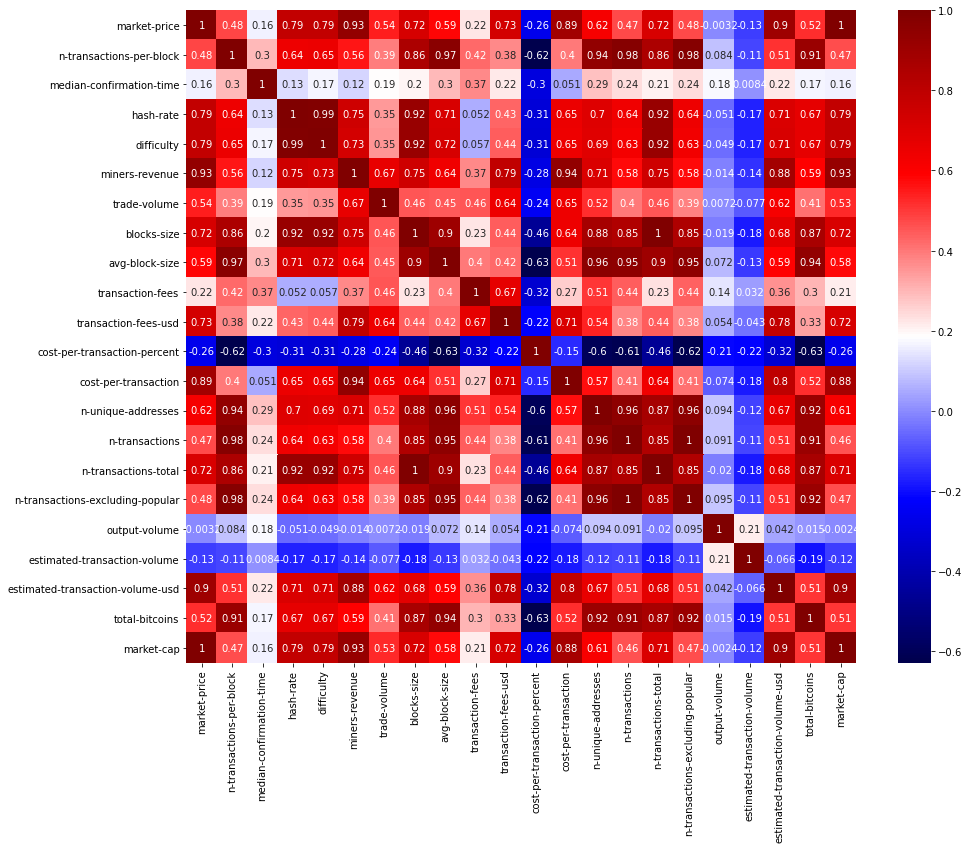

In [15]:
#Pearson Correlation of the variables
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df_blockchain.corr(), cmap='seismic', annot=True, ax=ax)

The variables hash-rate and difficulty are very high correlated so we can study only one of them. We can do the same with the three variables n-transaction, n-transaction-excluding-popular and n-transactions-per-block.

### Study the correlation

With the correlation matrix, we see that the three most correlated with market-price are the miners-revenue, the estimated-transaction-volume-usd and the cost-per-transaction. We will draw linear regression between the market price and these three values.

Text(0.5, 1.0, 'R^2 = 0.87')

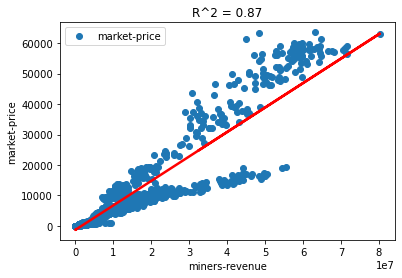

In [16]:
###Linear regression price=f(miners-revenue) 

X = df_blockchain["miners-revenue"][:-1] ##delete the last because nan
X = sm.add_constant(X)  # add the intercept term => necessary with statsmodels regression
y = df_blockchain["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

# Drawing the regression line on top of the scatterplot
fig = df_blockchain.plot(x="miners-revenue", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_blockchain['miners-revenue'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

Text(0.5, 1.0, 'R^2 = 0.82')

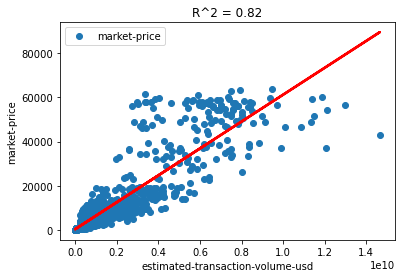

In [17]:
###Linear regression price=f(estimated-transaction-volume-usd) 

X = df_blockchain["estimated-transaction-volume-usd"][:-1] ##delete the last because nan
X = sm.add_constant(X)  # add the intercept term => necessary with statsmodels regression
y = df_blockchain["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

# Drawing the regression line on top of the scatterplot
fig = df_blockchain.plot(x="estimated-transaction-volume-usd", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_blockchain['estimated-transaction-volume-usd'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

Text(0.5, 1.0, 'R^2 = 0.78')

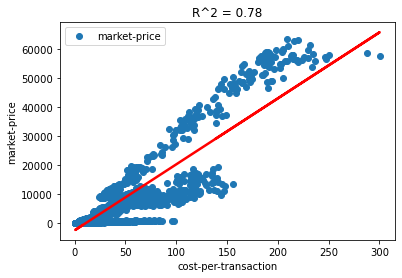

In [18]:
###Linear regression price=f(cost-per-transaction) 

X = df_blockchain["cost-per-transaction"][:-1] ##delete the last because nan
X = sm.add_constant(X)  # add the intercept term => necessary with statsmodels regression
y = df_blockchain["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

# Drawing the regression line on top of the scatterplot
fig = df_blockchain.plot(x="cost-per-transaction", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_blockchain['cost-per-transaction'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

We notice that the linear regression are quite good, but for both first and last one there are several linear directions to the market-price, that can't be modelise by an unique linear regression. Thus, we'll study only the data set after the second halving, and see if these directions are still here with recent data.

## Studying the recent data (after 9/7/16)
We begin to select the recent data.

In [19]:
df_recent = df_blockchain.iloc[1761:, :]

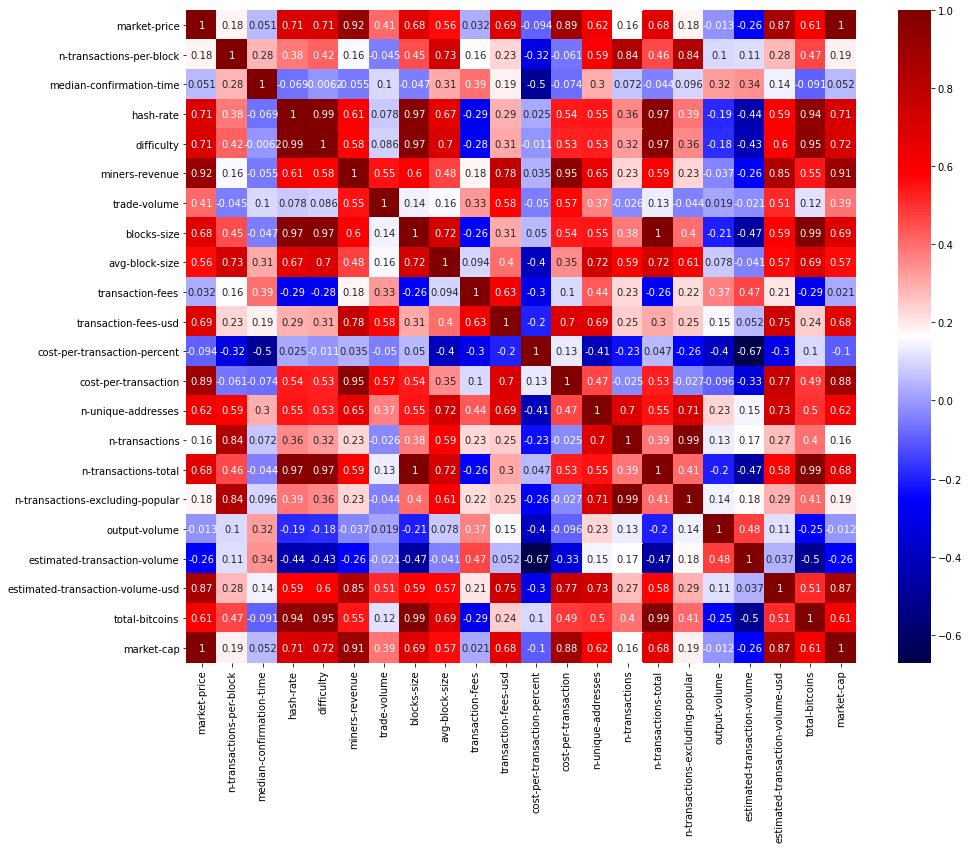

In [20]:
#Pearson Correlation of the variables
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df_recent.corr(), cmap='seismic', annot=True, ax=ax)

Text(0.5, 1.0, 'R^2 = 0.85')

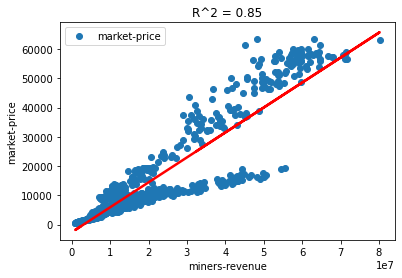

In [21]:
###Linear regression price=f(miners-revenue) 

X = df_recent["miners-revenue"][:-1] ##delete the last because nan
X = sm.add_constant(X)  # add the intercept term => necessary with statsmodels regression
y = df_recent["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

# Drawing the regression line on top of the scatterplot
fig = df_recent.plot(x="miners-revenue", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_recent['miners-revenue'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

Text(0.5, 1.0, 'R^2 = 0.77')

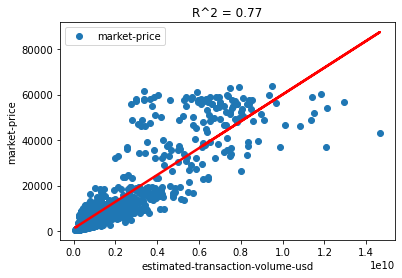

In [22]:
###Linear regression price=f(estimated-transaction-volume-usd) 

X = df_recent["estimated-transaction-volume-usd"][:-1] ##delete the last because nan
X = sm.add_constant(X)  # add the intercept term => necessary with statsmodels regression
y = df_recent["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

# Drawing the regression line on top of the scatterplot
fig = df_recent.plot(x="estimated-transaction-volume-usd", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_recent['estimated-transaction-volume-usd'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

Text(0.5, 1.0, 'R^2 = 0.80')

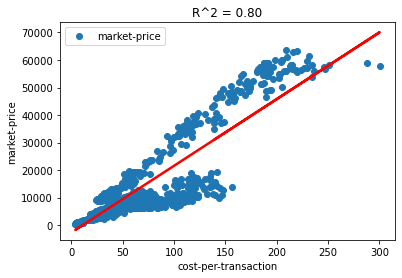

In [23]:
###Linear regression price=f(cost-per-transaction) 

X = df_recent["cost-per-transaction"][:-1] ##delete the last because nan
X = sm.add_constant(X)  # add the intercept term => necessary with statsmodels regression
y = df_recent["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

# Drawing the regression line on top of the scatterplot
fig = df_recent.plot(x="cost-per-transaction", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_recent['cost-per-transaction'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

The minor directions are still here (one has been removed for cost-per-transaction). We must try with the data after the third halving.

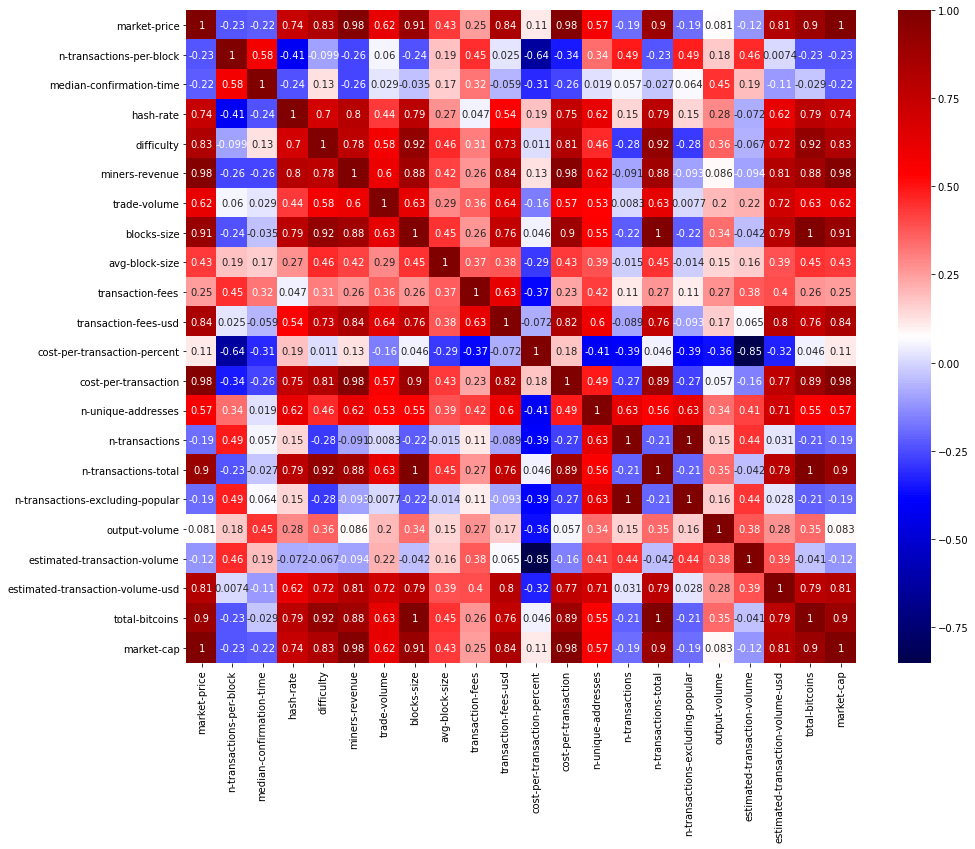

In [24]:
df_very_recent = df_blockchain.iloc[3163:, :]

#Pearson Correlation of the variables
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df_very_recent.corr(), cmap='seismic', annot=True, ax=ax)

The correlations have clearly changed, and we can't keep the same conclusions as before. Let's see if the linear regression works better.

Text(0.5, 1.0, 'R^2 = 0.97')

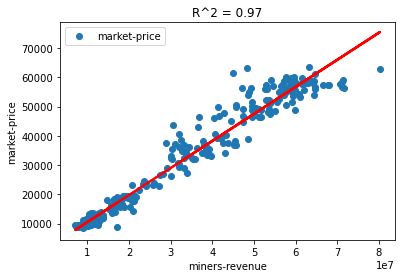

In [25]:
###Linear regression price=f(miners-revenue) 

X = df_very_recent["miners-revenue"][:-1] ##delete the last because nan
X = sm.add_constant(X)  # add the intercept term => necessary with statsmodels regression
y = df_very_recent["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

# Drawing the regression line on top of the scatterplot
fig = df_very_recent.plot(x="miners-revenue", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_very_recent['miners-revenue'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

Text(0.5, 1.0, 'R^2 = 0.97')

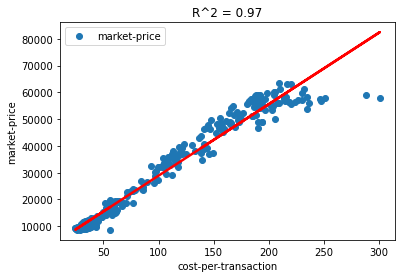

In [26]:
###Linear regression price=f(cost-per-transaction) 

X = df_very_recent["cost-per-transaction"][:-1] ##delete the last because nan
X = sm.add_constant(X)  # add the intercept term => necessary with statsmodels regression
y = df_very_recent["market-price"][:-1]

ols = sm.OLS(y, X).fit()
ols.summary()

# Drawing the regression line on top of the scatterplot
fig = df_very_recent.plot(x="cost-per-transaction", y="market-price", style="o")
fig.set_ylabel("market-price")
ypred = ols.predict(X)
fig.plot(df_very_recent['cost-per-transaction'][:-1], ypred, 'r', linewidth=2.5)
fig.set_title('R^2 = {:.2f}'.format(ols.rsquared))

The linear regressions are working much better now, and only the main direction is here. Nevertheless, we want to know what is the cause of the secondary directions.

We notice that the directions previously observed are related to the dates of high market-price : november 2013, december 2017, march 2021. These 3 events happened around 1 year after each halving. Thus, we think that the directions of market-price are a consequence of the halvings, and we should only keep the data after the third halving in order to do a linear regression that modelises the current situation.

## Train test split

In [27]:
X_train, X_test = hf.data_split(df_blockchain)

In [28]:
X_train

,Date,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
0,2011-09-13,6.88,45.908451,0.000000,1.201882e+01,1.777774e+06,5.231801e+04,0.000000e+00,592.190091,0.019009,...,7.666766,12622.0,6519.0,1497195.0,6519.0,3.585436e+05,58615.641320,4.032756e+05,7.257416e+06,5.022014e+07
1,2011-09-14,6.19,42.465753,0.000000,1.326393e+01,1.755425e+06,4.830647e+04,0.000000e+00,594.907367,0.018007,...,7.369408,12408.0,6200.0,1503780.0,6200.0,3.026190e+05,74521.484625,4.612880e+05,7.264662e+06,4.540930e+07
2,2011-09-15,5.92,41.500000,0.000000,1.291487e+01,1.755425e+06,6.043144e+04,0.000000e+00,597.554226,0.018240,...,7.333913,12988.0,6474.0,1509972.0,6474.0,2.992261e+05,79422.402932,4.701806e+05,7.272284e+06,4.322228e+07
3,2011-09-16,5.58,52.176471,0.000000,1.099510e+01,1.755425e+06,3.434502e+04,0.000000e+00,600.362512,0.022136,...,5.466341,12059.0,6209.0,1516381.0,6209.0,6.746069e+05,82696.853247,4.614484e+05,7.279040e+06,4.088136e+07
4,2011-09-17,5.18,40.701493,0.000000,1.073331e+01,1.755425e+06,3.680591e+04,0.000000e+00,602.995510,0.017116,...,6.489054,10988.0,5454.0,1522600.0,5454.0,3.541989e+05,68238.166521,3.534737e+05,7.285375e+06,3.801833e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3509,2021-04-22,53808.80,1920.349650,10.666667,1.676341e+08,2.358198e+13,6.429395e+07,6.294209e+08,340456.355086,1.276191,...,234.128229,757844.0,274610.0,635849023.0,269592.0,2.189518e+06,157972.362817,8.500130e+09,1.868829e+07,1.011151e+12
3510,2021-04-23,51731.71,2190.600000,12.100000,1.582560e+08,2.358198e+13,5.556738e+07,1.187406e+09,340638.819333,1.315820,...,187.898411,794322.0,295731.0,636123674.0,290057.0,2.184878e+06,230771.360532,1.148612e+10,1.868916e+07,9.350666e+11
3511,2021-04-24,51153.13,2004.758621,13.200000,1.699787e+08,2.358198e+13,5.387773e+07,1.413848e+09,340816.370766,1.326226,...,185.344294,695216.0,290690.0,636418250.0,285889.0,1.601340e+06,78195.467366,3.907764e+09,1.869003e+07,9.373611e+11
3512,2021-04-25,50110.53,1709.510638,12.000000,1.652896e+08,2.358198e+13,4.945331e+07,4.582743e+08,341008.684802,1.342451,...,205.165565,585806.0,241041.0,636708684.0,236534.0,1.637220e+06,114196.701243,5.690337e+09,1.869093e+07,9.308049e+11


# Modeling with ARIMA
In this section, you are to perform some classical modelings, the suggested method here is ARIMA, but you can try other models such as ARMA, ARIMAX, SARIMAX...

## Modeling
The following code allows ARIMA modeling with one combination of (p,d,q).

In [26]:
#If you need information about the function, you can display the docstring
hf.evaluate_arima_model?

In [29]:
parameters = (2,1,1)
errors, predictions = hf.evaluate_arima_model(X_train["market-price"], 
                                              X_test["market-price"], parameters )
errors

AttributeError: module 'helper_functions' has no attribute 'evaluate_arimax_model'

## Search for the best ARIMA model
We use grid search to search for the best ARIMA parameters that gives the lowest error. This follows the Box-Jenkins methology.

In [31]:
best_cfg, best_score = hf.arima_grid_search(X_train["market-price"], 
                                            X_test["market-price"],
                                            np.arange(1,3), np.arange(3), np.arange(3))

C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglike, sigma2 = kalman_loglike.kalman_loglike_double(


ARIMA(1,0,0) RMSE=2928.575
ARIMA(1,1,0) RMSE=2893.997
ARIMA(1,1,1) RMSE=2885.169
ARIMA(1,1,2) RMSE=2853.029
ARIMA(1,2,0) RMSE=3400.850
ARIMA(1,2,1) RMSE=2929.925


C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1,2,2) RMSE=2922.657


C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to

ARIMA(2,0,0) RMSE=2959.347
ARIMA(2,1,0) RMSE=2860.905
ARIMA(2,1,1) RMSE=2855.364


C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\axelc\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:450: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
C:\Users\axelc\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:450: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
C:\Users\axelc\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:465: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1
C:\Users\axelc\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:470: RuntimeWarning: invalid value encountered in subt

ARIMA(2,2,0) RMSE=3240.463
ARIMA(2,2,1) RMSE=2889.523


C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\axelc\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


ARIMA(2,2,2) RMSE=2927.102
Best ARIMA(1, 1, 2) MSE=2853.029


## Seasonal Decomposition
We are trying to find a decomposition of the market-price serie thanks to the function seasonal_decompose of statsmodels, in order to use SARIMAX.

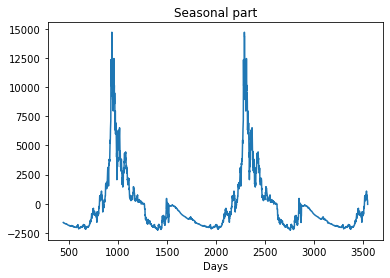

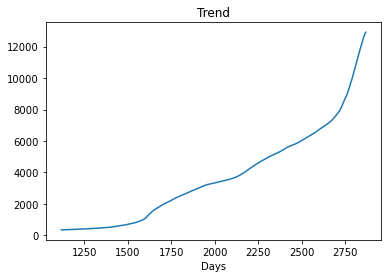

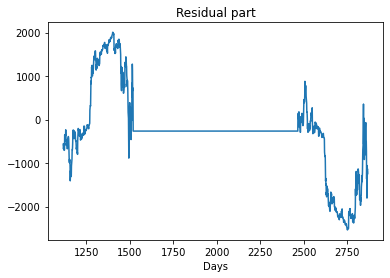

In [4]:
#Trying a Seasonal decomposition, with a period equal to the time between two halving (beginning on the first halving)
decomposition = seasonal_decompose(df_blockchain["market-price"][442:], model='additive', period=1350)

season = decomposition.seasonal
trend = decomposition.trend
resid = decomposition.resid

time = np.linspace(0, len(df_blockchain["market-price"])-1, len(df_blockchain["market-price"]))
plt.plot(time[442:], season)
plt.title('Seasonal part')
plt.xlabel('Days')
plt.show()

plt.plot(time[442:], trend)
plt.title('Trend')
plt.xlabel('Days')
plt.show()

plt.plot(time[442:], resid)
plt.title('Residual part')
plt.xlabel('Days')
plt.show()

The residual serie has a huge weight in the decomposition given, so we can't decompose the market-price serie with respect to the cycles of halving. We already saw before that the price has no yearly seasonality. Thus, there is no need to use SARIMAX to model the serie.

## Visualization of the best ARIMA
To have a better view on the difference between true and predict values, we visualize them by plotting both the signals.

In [18]:
# prepare the dataset for plotting
predict_date = df_blockchain.iloc[-30::]["Date"]
df_predict = pd.DataFrame(zip(predict_date,
                              predictions, X_test["market-price"].values),
                          columns=["date", "predict", "true"])

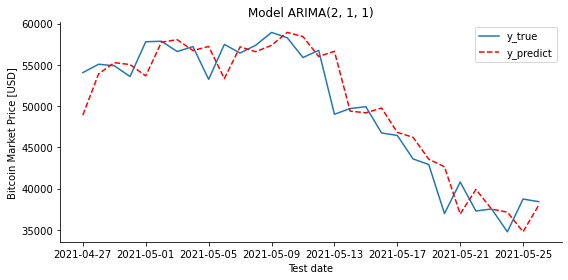

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="date", y="true", data=df_predict, 
             ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict",
             data=df_predict,
             color="red",ax=ax, label="y_predict")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
ax.set_title(f"Model ARIMA{parameters}")
sns.despine()
plt.legend()
plt.tight_layout()
